In [146]:
from TimeSeriesData import prepare_dataframe_for_LSTM, split_train_test, reshape_data
from TimeSeriesData import TimeSeriesDataset
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from copy import deepcopy as dc
from LSTM import LSTM, train_one_epoch, val_one_epoch, CNN_LSTM, LSTM_CNN
import matplotlib.pyplot as plt
import math

In [147]:
configuration = {
    "window_size": 120,
    "spliting_ratio": 0.9,
    "batch_size": 32,
    "hidden_size": 36,
    "num_layers": 2,
    "LR": 1e-4,
    "num_epoch": 800,
    "val_interval": 10,
    "patience": 7
}

In [148]:
stock1 = "ICE"
stock2 = "SHW"
spread = pd.read_csv(f"../data/spread/spread_{stock1}_{stock2}.csv", index_col=0)
spread.index = pd.to_datetime(spread.index)
spread.head()

,Spread
Date,
2016-01-04,0.424122
2016-01-05,0.240802
2016-01-06,0.173629
2016-01-07,0.078770
2016-01-08,0.210638


In [149]:
window_size = configuration["window_size"]
shifted_df = prepare_dataframe_for_LSTM(spread, window_size=window_size)
shifted_df.head()

C:\Users\18363\Desktop\course materials\capstone project\pairs trading with machine learning\LSTM_spread_forecasting\TimeSeriesData.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Spread(t-{i})'] = df['Spread'].shift(i)
C:\Users\18363\Desktop\course materials\capstone project\pairs trading with machine learning\LSTM_spread_forecasting\TimeSeriesData.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Spread(t-{i})'] = df['Spread'].shift(i)
C:\Users\18363\Desktop\course materials\capstone project\pairs trading wit

,Spread,Spread(t-1),Spread(t-2),Spread(t-3),Spread(t-4),Spread(t-5),Spread(t-6),Spread(t-7),Spread(t-8),Spread(t-9),...,Spread(t-111),Spread(t-112),Spread(t-113),Spread(t-114),Spread(t-115),Spread(t-116),Spread(t-117),Spread(t-118),Spread(t-119),Spread(t-120)
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-24,1.147014,0.930133,1.082155,1.069636,1.068650,0.996629,0.944433,0.952744,0.927550,0.830683,...,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629,0.240802,0.424122
2016-06-27,1.218416,1.147014,0.930133,1.082155,1.069636,1.068650,0.996629,0.944433,0.952744,0.927550,...,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629,0.240802
2016-06-28,1.205317,1.218416,1.147014,0.930133,1.082155,1.069636,1.068650,0.996629,0.944433,0.952744,...,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629
2016-06-29,1.066656,1.205317,1.218416,1.147014,0.930133,1.082155,1.069636,1.068650,0.996629,0.944433,...,0.560437,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770
2016-06-30,1.024471,1.066656,1.205317,1.218416,1.147014,0.930133,1.082155,1.069636,1.068650,0.996629,...,0.336349,0.560437,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638


In [150]:
shifted_df_as_np = shifted_df.values
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))
# flip the column to have Spread(t-N), Spread(t-N+1), ..., Spread(t-2), Spread(t-1)

print(X.shape, y.shape)

(1989, 120) (1989,)


In [151]:
train_proportion = configuration["spliting_ratio"]
X_train, y_train, X_test, y_test = split_train_test(X, y, train_proportion)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1790, 120) (1790,) (199, 120) (199,)


In [152]:
X_train, y_train = reshape_data(X_train, y_train, window_size=window_size)
X_test, y_test = reshape_data(X_test, y_test, window_size=window_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([1790, 120, 1]) torch.Size([1790, 1]) torch.Size([199, 120, 1]) torch.Size([199, 1])


In [153]:
train_set = TimeSeriesDataset(X_train, y_train)
validation_set = TimeSeriesDataset(X_test, y_test)

batch_size = configuration["batch_size"]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [154]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 120, 1]) torch.Size([32, 1])


In [155]:
cnn_lstm_model = CNN_LSTM(input_size=1, hidden_size=configuration["hidden_size"],
                          num_layers=configuration["num_layers"], device=device)
cnn_lstm_model.to(device)
cnn_lstm_model

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=same)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(8, 36, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=36, out_features=1, bias=True)
)

In [156]:
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=configuration['LR'])
log = {
    "train_loss": [],
    "val_loss": []
}
best_val_loss = math.inf
best_model_weights = None
tolerance = configuration["patience"]

for epoch in range(1, configuration["num_epoch"]+1):
    print(f"Epoch {epoch}: ", end='')
    train_loss = train_one_epoch(cnn_lstm_model, train_loader=train_loader, optimizer=optimizer, device=device)
    log["train_loss"].append(train_loss)
    if epoch % configuration["val_interval"] == 0:
        val_loss = val_one_epoch(cnn_lstm_model, val_loader=val_loader, device=device)
        log["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = dc(cnn_lstm_model.state_dict())
            tolerance = configuration["patience"]
        else: # early stopping
            tolerance -= 1
            if tolerance == 0: break

cnn_lstm_model.load_state_dict(best_model_weights)
print(f"Best validation loss: {best_val_loss}")

Epoch 1: Training loss :1.045517
Epoch 2: Training loss :1.019302
Epoch 3: Training loss :0.977065
Epoch 4: Training loss :0.865259
Epoch 5: Training loss :0.647535
Epoch 6: Training loss :0.547746
Epoch 7: Training loss :0.491466
Epoch 8: Training loss :0.443657
Epoch 9: Training loss :0.393421
Epoch 10: Training loss :0.346552
Validation loss :0.207932
*************************************************
Epoch 11: Training loss :0.304581
Epoch 12: Training loss :0.270859
Epoch 13: Training loss :0.246854
Epoch 14: Training loss :0.235597
Epoch 15: Training loss :0.216784
Epoch 16: Training loss :0.203510
Epoch 17: Training loss :0.194993
Epoch 18: Training loss :0.189422
Epoch 19: Training loss :0.174497
Epoch 20: Training loss :0.166963
Validation loss :0.150178
*************************************************
Epoch 21: Training loss :0.156450
Epoch 22: Training loss :0.153925
Epoch 23: Training loss :0.146592
Epoch 24: Training loss :0.139724
Epoch 25: Training loss :0.136937
Epoch 2

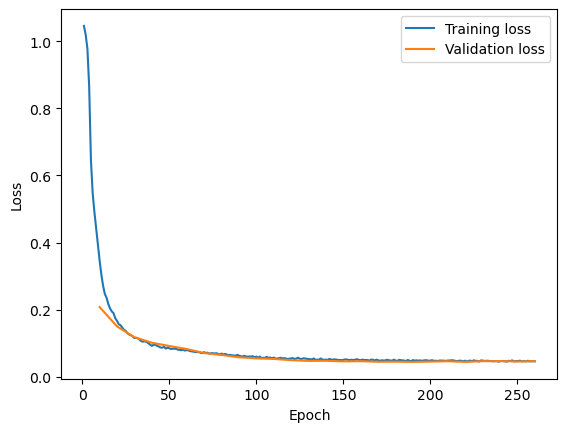

In [157]:
plt.plot(range(1, len(log["train_loss"])+1), log["train_loss"], label="Training loss")
plt.plot(range(10, len(log["train_loss"])+1, configuration["val_interval"]), log["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

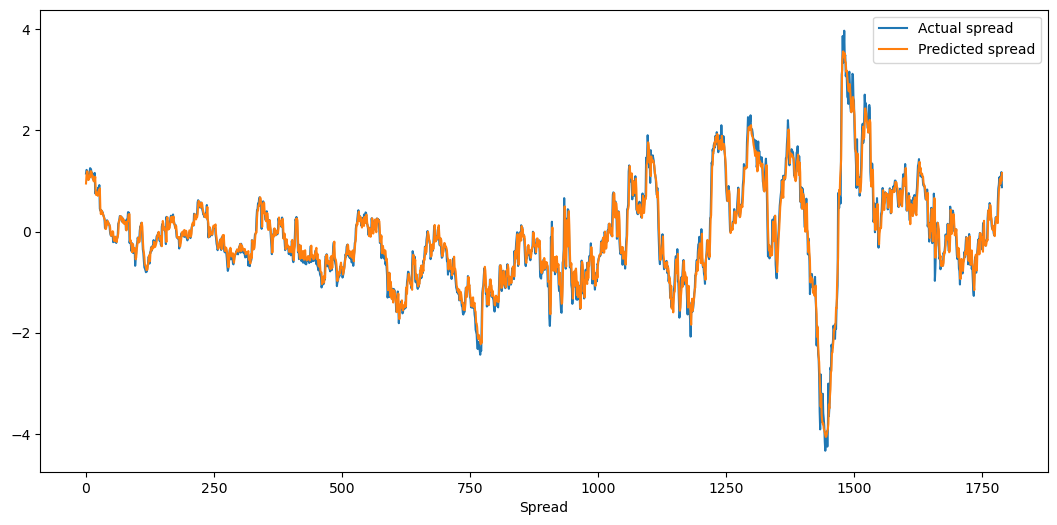

In [158]:
with torch.no_grad():
    train_predicted = cnn_lstm_model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(13, 6))
plt.plot(y_train, label="Actual spread")
plt.plot(train_predicted, label="Predicted spread")
plt.xlabel("Day")
plt.xlabel("Spread")
plt.legend()
plt.show()

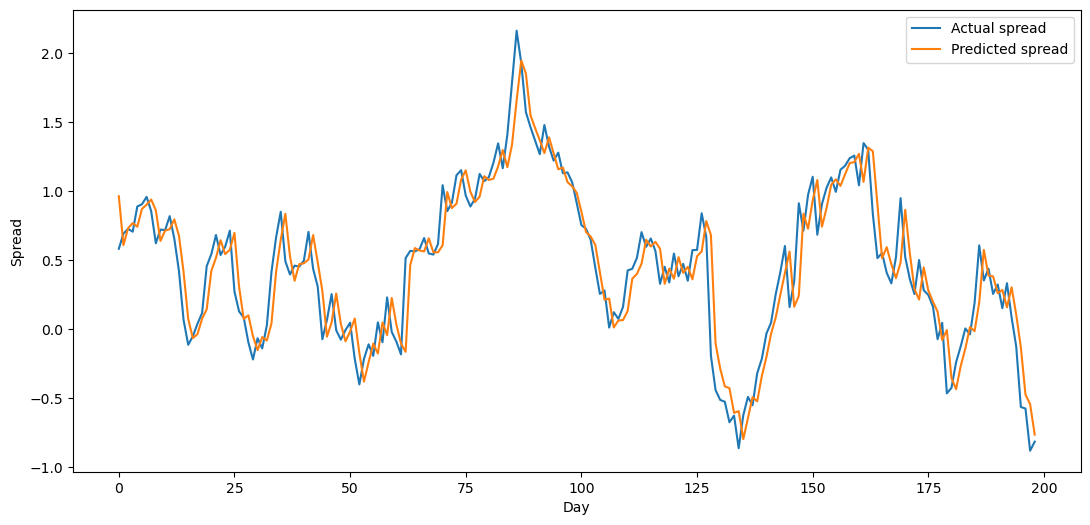

In [159]:
with torch.no_grad():
    test_predicted = cnn_lstm_model(X_test.to(device)).to('cpu').numpy()

plt.figure(figsize=(13, 6))
plt.plot(y_test, label="Actual spread")
plt.plot(test_predicted, label="Predicted spread")
plt.xlabel("Day")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [160]:
torch.save(cnn_lstm_model, f"./models/CNN_LSTM_{stock1}_{stock2}.pth")

In [161]:
test_predicted_df = pd.DataFrame(test_predicted)
test_predicted_df.to_csv(f"./validation_result/CNN_LSTM_{stock1}_{stock2}.csv")